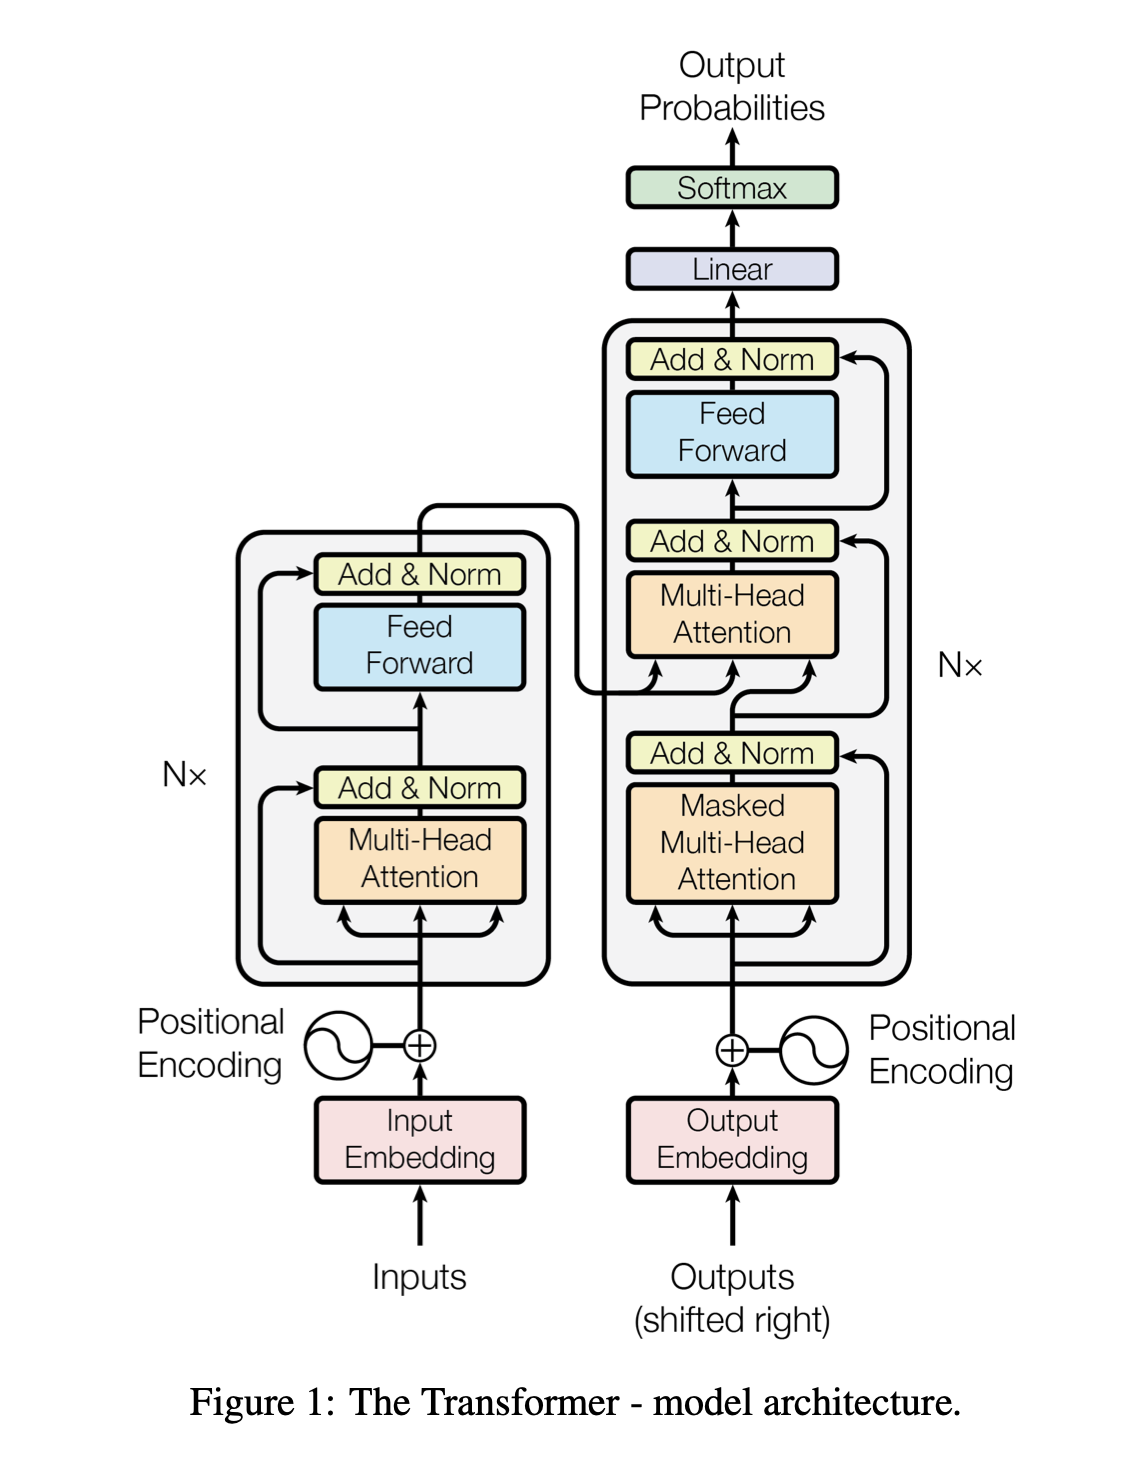

In [13]:
import torch
from torch import nn
from torch import tensor
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import pickle
import os
import matplotlib.pyplot as plt

In [5]:
def shape_data(X:tensor, batch_size:int, seq_length:int, model_dim:int) -> tensor:
    # Creates a 3-D maxtrix of shape (batch_size, seq_length, model_dim)
    
    overall_size = batch_size*seq_length*model_dim
    if len(X.flatten()) < overall_size:
        X = X.flatten()
        print(f'Padding input with {overall_size-len(X)} 0s...')
        X = torch.concatenate([X, torch.zeros(overall_size-len(X))])

    elif len(X.flatten()) > overall_size:
        print(f'Truncating input to {overall_size}...')
        X = X.flatten()[:overall_size]

    return X.view(batch_size, seq_length, model_dim)

### Attention Mechanism

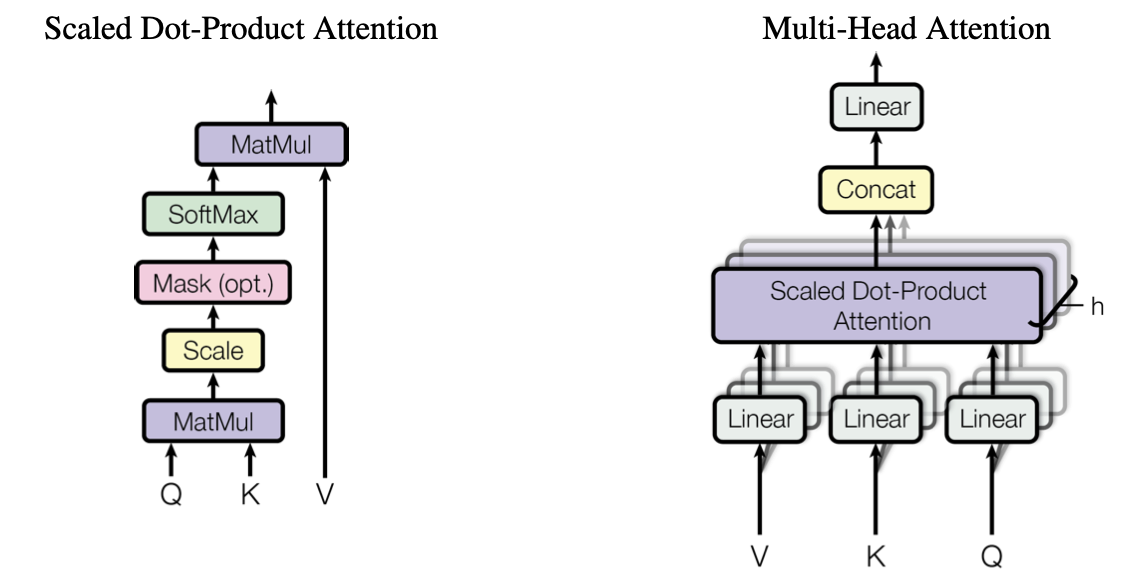

In [6]:
class ScaledDotProductAttention():
    def __init__(self):
        pass
    
    @staticmethod
    def attn(Q:tensor, K:tensor, V:tensor, mask=None) -> tensor:        
        if len(K.shape)==4: # handle for if it's a matrix instead of a vector
            scale = np.sqrt(K.shape[-1])
            attention_values = torch.matmul(Q, K.transpose(-2, -1))/scale
        else:  
            scale = np.sqrt(K.shape[0])
            attention_values = torch.matmul(Q, K.T)/scale
        
        if mask is not None:
            # unsqueeze to add extra dimensions
            if len(mask.shape) == 2:
                mask = mask.unsqueeze(1).unsqueeze(2)
            attention_values = attention_values.masked_fill(mask == 0, -1e9)
            
        softmax = F.softmax(attention_values, dim=-1)
        
        output = torch.matmul(softmax, V)
        
        # output shape: batch_size, num_heads, seq_length, head_dim)
        return output
    

In [7]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, model_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        assert model_dim % num_heads == 0, "Model must have a dimension divisible by # of heads."
        
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        
        # Need to learn Q, K, V weights
        self.wQ = nn.Linear(model_dim, model_dim)
        self.wK = nn.Linear(model_dim, model_dim)
        self.wV = nn.Linear(model_dim, model_dim)
        self.wOut = nn.Linear(model_dim, model_dim)
                
    def forward(self, X, Q=None, mask=None):
        # Q is option for decoder layer for cross-attention
        
        batch_size, seq_length, model_dim = X.size()
        if Q is not None:
            batch_size, seq_length, model_dim = Q.size()
                
        Q, K, V = self.wQ(X) if Q is None else self.wQ(Q), self.wK(X), self.wV(X)      
        
        # Need to reshape as (batch_size, num_heads, seq_length, head_dim)
        def reshape(inp_tensor):
            batch_size, seq_length, model_dim = inp_tensor.size()
            return inp_tensor.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        
        Q, K, V = reshape(Q), reshape(K), reshape(V)

        attention_values = ScaledDotProductAttention.attn(Q, K, V, mask)
        comb_attn = attention_values.transpose(1, 2).contiguous()
        comb_attn = comb_attn.view(batch_size, seq_length, model_dim)
        
        # Final linear layer. Shape (batch_size, seq_length, model_dim)
        output = self.wOut(comb_attn)
        return output
        

**Excerpt:** "...each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between."

In [8]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, model_dim:int, ff_dim:int):
        # ff_dim == dimension of feed forward network (original value in paper is 2048)
        super(PositionwiseFeedForward, self).__init__()
        self.w1 = nn.Linear(model_dim, ff_dim)
        self.w2 = nn.Linear(ff_dim, model_dim)

    def forward(self, x):
        # max(0, xW1 + b1 )W2 + b2
        # |____  |_______| |______|
        #    ^      ^          ^
        #    |      |          | 
        #    |     NN 1 (w1)   |
        #  ReLu                |
        #                    NN 2 (w2)
        return self.w2( F.relu( self.w1(x) ) )

In [9]:
class PositionalEncodings():
    def __init__(self, seq_length:int, model_dim:int):
#        super(PositionalEncodings, self).__init__()
        
#         assert len(X.shape) == 3, "Excepting input to be 3 dimensions of (batch_size, seq_length, model_dim)"
        
#         _, seq_length, model_dim = X.shape

        positional_encodings = torch.ones(size=(seq_length, model_dim)).float()

        positions = torch.arange(0, seq_length).float().unsqueeze(1)
        i = torch.arange(0, model_dim, 2)

        div_func = lambda i: np.power(10000, (i / model_dim))
        divisor = torch.arange(0, model_dim, 2).float().apply_(div_func)
        sin = torch.sin(positions / divisor)
        cos = torch.cos(positions / divisor)

        positional_encodings[:, 0::2] = sin
        positional_encodings[:, 1::2] = cos
        
        positional_encodings = positional_encodings.view(seq_length, model_dim)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.positional_encodings = positional_encodings.to(device)
    
    def __call__(self, X):
        return X+self.positional_encodings[:X.shape[1], :] # the decoder inputs will be 1 less than encoder inputs
    
#    def forward(self, X):
#        return X+self.positional_encodings

Y-axis: Sequence (In our case, a sentence of words, so 100 words here)
X-axis: Model dimension (each word is represented by a 512 dimension space)


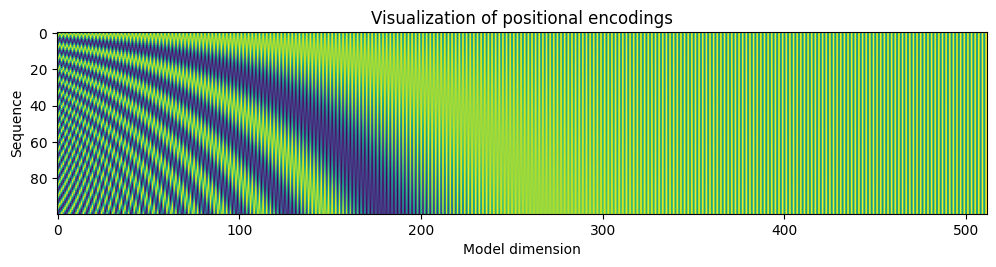

In [23]:
pe = PositionalEncodings(seq_length=100, model_dim=512)

plt.figure(figsize=(12, 7))
plt.imshow(pe.positional_encodings);
plt.title('Visualization of positional encodings')
plt.ylabel("Sequence");
print("Y-axis: Sequence (In our case, a sentence of words, so 100 words here)")
plt.xlabel("Model dimension");
print("X-axis: Model dimension (each word is represented by a 512 dimension space)")

Each row is a 'word' and each column is a feature space value
In this case, word 0 is represented as a 512 length vector of 0s 
	word 1 is represented as a 512 length vector of 1s 
	....
	word 99 is represented as a 512 length vector of 99s


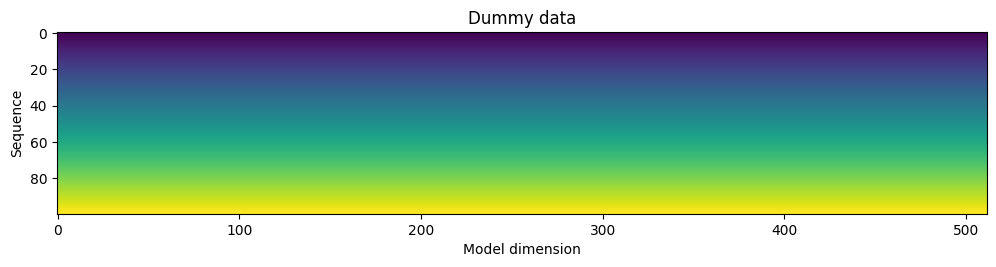

In [47]:
dummy_data = torch.arange(100).view(-1, 1).expand(-1, 512)/50 # diving arbitaritly to make subsequnet graph pop
plt.figure(figsize=(12, 7))
plt.imshow(dummy_data);
plt.title("Dummy data");
plt.xlabel("Model dimension");
plt.ylabel("Sequence");
print("Each row is a 'word' and each column is a feature space value")
print("In this case, word 0 is represented as a 512 length vector of 0s \n\tword 1 is represented as a 512 length vector of 1s \n\t....\n\tword 99 is represented as a 512 length vector of 99s")

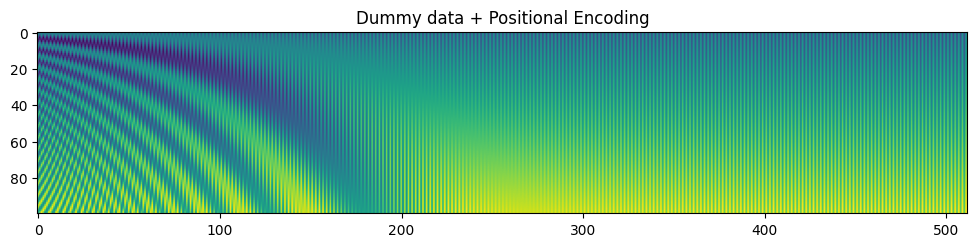

In [49]:
plt.figure(figsize=(12, 7))
plt.title("Dummy data + Positional Encoding");
plt.imshow(pe(dummy_data));

### Encoder:

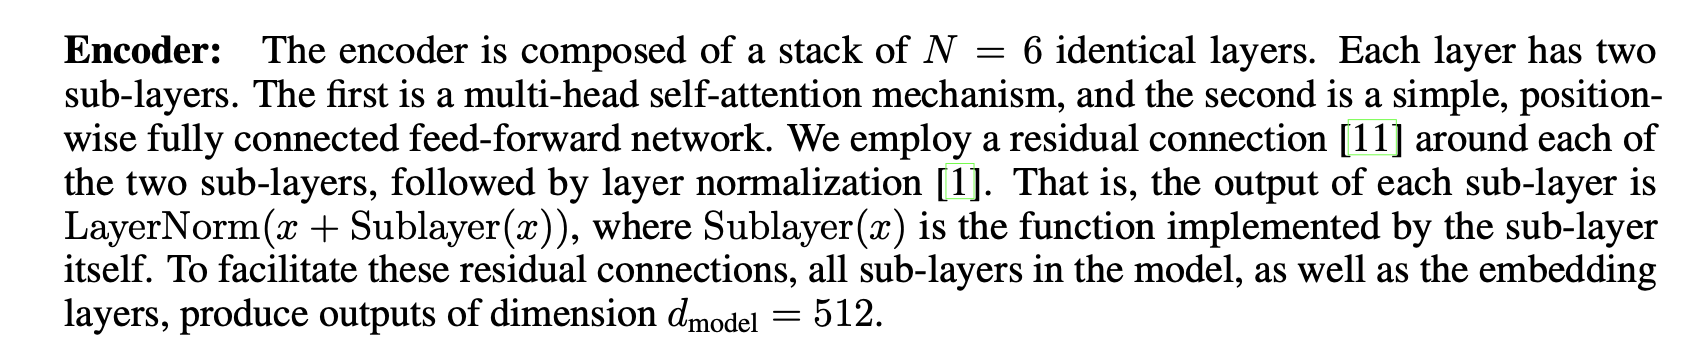

In [7]:
class EncoderBlock(nn.Module):
    def __init__(self, model_dim:int=512, num_heads:int=8, ff_dim:int=2048, dropout=0.1):
        """
        param: model_dim: the dimension of the attention mechanism (original paper is 512)
        param: num_heads: the number of attention layer heads to have (original paper is 8)
        param: ff_dim: the dimension of of the feed forward layer (original paper is 2048)
        param: dropout: the dropout rate for each of the layers (original paper is 0.1)
        """
        super(EncoderBlock, self).__init__()
        self.model_dim = model_dim
        
        self.attention_layer = MultiHeadSelfAttention(model_dim, num_heads)
        self.attention_layer_norm = nn.LayerNorm(model_dim)
        # Comperable to batch norm, that computes the mean and variance of a batch,
        # LayerNorm computes the mean and variance used for normalization from a single "body"
        # which in the above case is the mean and norm for the output attention layer matrix
        
        self.ffn = PositionwiseFeedForward(model_dim, ff_dim)
        self.ffn_norm = nn.LayerNorm(model_dim)
        
        # Original paper also applies a dropout to each sublayer of P(dropout) = 0.1
        self.dropout = nn.Dropout(dropout)
                
    def forward(self, X, mask=None):
        # LayerNorm(X + SubLayer(X))
                        
        X = self.attention_layer_norm(X + self.dropout(self.attention_layer(X, mask=mask)))
        
        X = self.ffn_norm(X + self.dropout(self.ffn(X)))
        
        return X

# SIMPLE! :)

### Decoder:

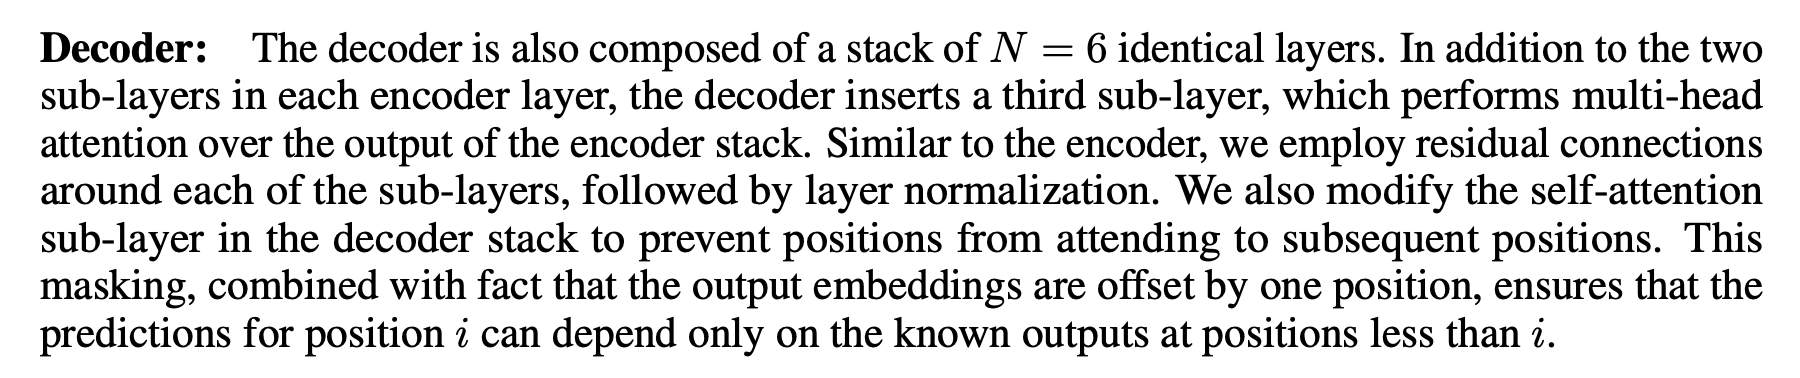

In [8]:
class DecoderBlock(nn.Module):
    def __init__(self, model_dim:int=512, num_heads:int=8, ff_dim:int=2048, dropout=0.1):
        """
        param: model_dim: the dimension of the attention mechanism (original paper is 512)
        param: num_heads: the number of attention layer heads to have (original paper is 8)
        param: ff_dim: the dimension of of the feed forward layer (original paper is 2048)
        param: dropout: the dropout rate for each of the layers (original paper is 0.1)
        """
        super(DecoderBlock, self).__init__()
        
        self.self_attention_layer = MultiHeadSelfAttention(model_dim, num_heads)
        self.self_attention_norm = nn.LayerNorm(model_dim)
        
        # add in a cross-attention layer to fold in the encoder outputs
        self.cross_attention_layer = MultiHeadSelfAttention(model_dim, num_heads)
        self.cross_attention_norm = nn.LayerNorm(model_dim)
        
        self.ffn = PositionwiseFeedForward(model_dim, ff_dim)
        self.ffn_norm = nn.LayerNorm(model_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, X:tensor, encoder_output:tensor, decoder_mask=None, encoder_mask=None):
            
        self_attention = self.self_attention_layer(X, mask=decoder_mask) # mask the self-attn layer to not look at the future
        self_attention = self.self_attention_norm(X + self.dropout(self_attention))
        
        # Excerpt:  "In 'encoder-decoder' attention layers, the queries come from the previous decoder layer,
        # and the memory keys and values come from the output of the encoder."
        cross_attention = self.cross_attention_layer(X=encoder_output, Q=self_attention, mask=encoder_mask)
        cross_attention = self.cross_attention_norm(self_attention + self.dropout(cross_attention))
        
        X = self.ffn_norm(cross_attention + self.dropout(self.ffn(cross_attention)))
        return X
        

### Transfomer: Putting it all Together

In [9]:
class DAS_TRANSFORMER(nn.Module):
    def __init__(self, source_vocab_size:int, target_vocab_size:int, sequence_length:int, 
                 num_encoders:int=6, num_decoders:int=6,
                 model_dim:int=512,num_heads:int=8, ff_dim:int=2048, dropout:float=0.1,
                ):
        super(DAS_TRANSFORMER, self).__init__()
        
        # A simple lookup table that stores embeddings of a fixed dictionary and size
        # Tip: The encoder and decoder vocab sizes are needed to be different as we are translating
        # from one language to another in this case. (i.e. if we encode German, that vocab size will
        # be different from the availible vocab size in english to represent the original sentence)
        self.encoder_embedding = nn.Embedding(source_vocab_size, model_dim)
        self.decoder_embedding = nn.Embedding(target_vocab_size, model_dim)
        
        self.encoder = nn.ModuleList([EncoderBlock(model_dim, num_heads, ff_dim, dropout) for _ in range(num_encoders)])
        self.decoder = nn.ModuleList([DecoderBlock(model_dim, num_heads, ff_dim, dropout) for _ in range(num_decoders)])
        
        self.positional_encodings = PositionalEncodings(sequence_length, model_dim)
        
        self.FFN = nn.Linear(model_dim, target_vocab_size) # outputs logits of what the next sequential word could be
        
        self.dropout = nn.Dropout(dropout)
        
    @staticmethod
    def create_future_mask(inp:tensor, add_padding_mask=True):
        # Creates batch_size number of lower right triangular matricies so that the decoder can't look in the future
        # Assumption: 'inp' is of shape (batch_size, sequence_length)
        
        batch_size, seq_length = inp.size()
        future_mask = (torch.triu(torch.ones(seq_length, seq_length)) == 1).transpose(0, 1)
        future_mask = future_mask.unsqueeze(0).unsqueeze(1)  # Add two dimensions at the beginning
        future_mask = future_mask.expand(batch_size, -1, -1, -1)  # Expand the mask to match the batch size
        
        if add_padding_mask:
            padding_mask = (inp != 0)
            padding_mask = padding_mask.unsqueeze(1).unsqueeze(3)
            future_mask = future_mask & padding_mask
        return future_mask # mask is of shape (batch_size, 1, seq_length, seq_length)
    
    @staticmethod
    def create_padding_mask(inp):
        # Assumption: 'inp' is of shape (batch_size, sequence_length)
        mask = (inp != 0)
        # Attention is of shape (batch_size, num_heads, seq_length, seq_length)
        # Need to add in 1 dummy dimension for 'num_heads', and 'seq_length'
        mask = mask.unsqueeze(1).unsqueeze(2)
        return mask # mask is of shape (batch_size, 1, 1, seq_length)
        
    def forward(self, encoder_inp, decoder_inp):
        # encoder_inp, decoder_inp are often called 'source' and 'target' respectively
        
        # Embed and apply psoitional encodes the inputs
        source = self.positional_encodings(self.encoder_embedding(encoder_inp))
        target = self.positional_encodings(self.decoder_embedding(decoder_inp))
        
        # Excerpt: "we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks"
        source = self.dropout(source)
        target = self.dropout(target)
                
        source_mask = self.create_padding_mask(encoder_inp) # just has the transformer not look at useless "[PAD]" tokens (0)
        target_mask = self.create_future_mask(decoder_inp, add_padding_mask=True)
                                
        # Encode:
        encoding = source
        for encoder_block in self.encoder:
            encoding = encoder_block(encoding, source_mask)
                    
        # Decode:
        decoding = target
        for decoder_layer in self.decoder:
            decoding = decoder_layer(decoding, encoding, decoder_mask=target_mask, encoder_mask=source_mask)
        
        output = self.FFN(decoding)
        return output
    
    def __str__(self):
        return "Implmenting the 'Attention is All You Need' paper from scratch."

# Triaining
- In the original paper, the transformer was trained on "one machine with 8 NVIDIA P100 GPUs"
- Original dataset was the "WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs" and "WMT 2014 English-French dataset consisting of 36M sentences"
</br></br>
- I don't have this kind of compute so this will be scaled down

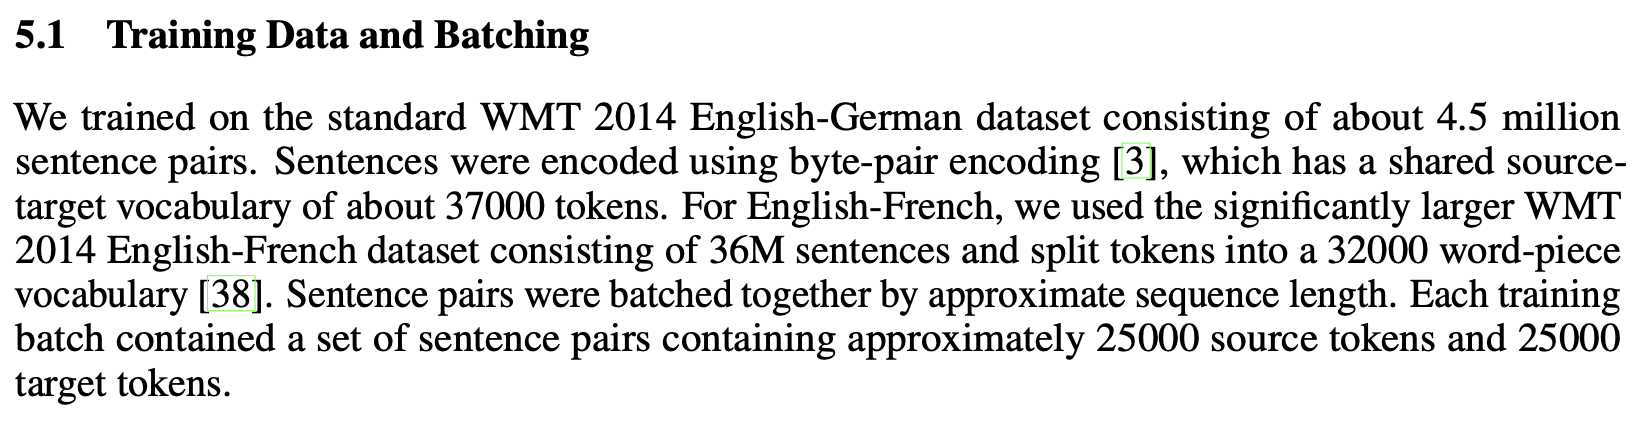

In [10]:
# I'll just be using the WMT 2014 English-German dataset
from datasets import load_dataset
dataset = load_dataset('wmt14', 'de-en', split=['train[:100000]', 'test'])

/Users/makiper/mambaforge/envs/MLE/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset wmt14 (/Users/makiper/.cache/huggingface/datasets/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
100%|█| 2/2 [00:00<00:00


In [11]:
print(f"Training length: {dataset[0].num_rows} | Testing length: {dataset[1].num_rows}")

Training length: 100000 | Testing length: 3003


In [12]:
dataset[0][0]['translation']

{'de': 'Wiederaufnahme der Sitzungsperiode', 'en': 'Resumption of the session'}

### Tokenize the data
- In order for the machine to understand text, we need to translate text into some discrete vector space
    - i.e. the sentence "hello there" becomes "12, 4920, 492, 121" with the mapping {"hell": 12, "o": 4920, "the": 492, "re": 121}
- Look into bag-of-words, byte-pair encoding, and word2vec

In [13]:
# CHEATING WITH BERT TOKENIZER 😬
# %time
from transformers import BertTokenizer

english_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
german_tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')

max_sequence_length = 100

def tokenize(inp):
    inp = inp['translation']
    encoder_inputs = english_tokenizer(inp['en'], truncation=True, padding='max_length', max_length=max_sequence_length)
    decoder_inputs = german_tokenizer(inp['de'], truncation=True, padding='max_length', max_length=max_sequence_length)
    
    tokenized = {'source_text': inp['en'], 
                 'target_text': inp['de'], 
                 'encoder_inputs': tensor(encoder_inputs['input_ids']), 
                 'encoder_mask': tensor(encoder_inputs['attention_mask']), 
                 'decoder_inputs': tensor(decoder_inputs['input_ids']),
                 'decoder_mask': tensor(decoder_inputs['attention_mask']), 
                }
    return tokenized

dataset_bert_tokens_train = dataset[0].map(tokenize)
dataset_bert_tokens_test = dataset[1].map(tokenize)

Loading cached processed dataset at /Users/makiper/.cache/huggingface/datasets/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4/cache-e0606092114013da.arrow
Loading cached processed dataset at /Users/makiper/.cache/huggingface/datasets/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4/cache-98564743d401e7c3.arrow


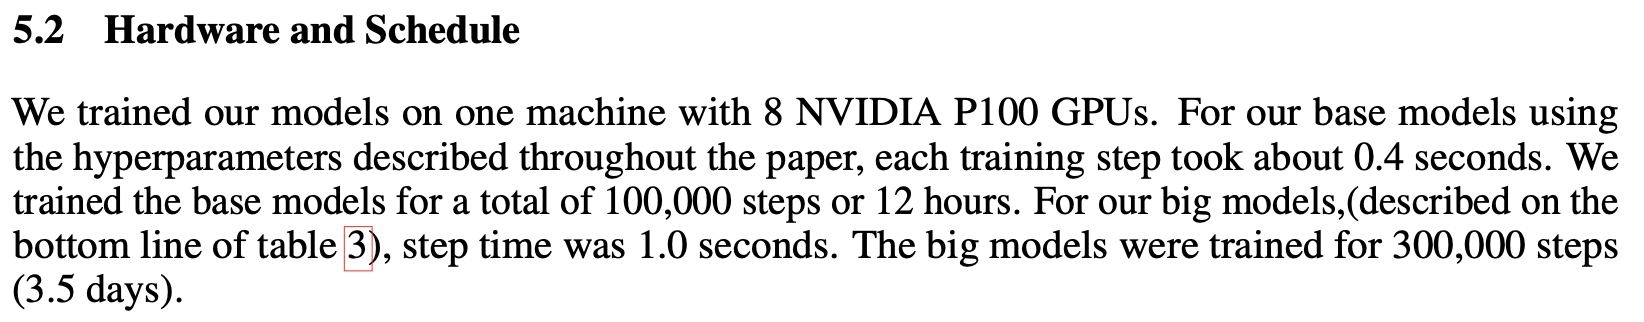

In [14]:
# Lol I am too broke to afford GPUs :////////

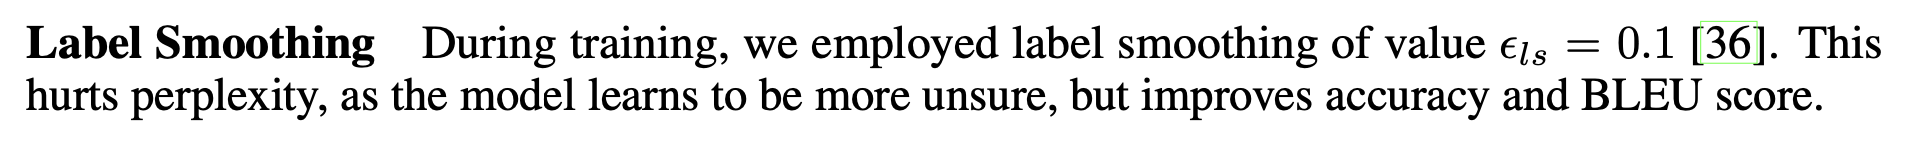

Why do we smooth the loss? This is because, in language there could be multiple ways to translate a sentence correctly. So, we don't want to have such strict penalties when the words to choose to translate are subjective to a degree.
- The smoothing actually penalizes when a model becomes too confident. So loss could increase after many training iterations
- The number of classes in this case would be the possible target vocab size

In [15]:
dummy_model_output_logits = tensor([
    # German token numbers:
    #   0        1         2       3        4 
    [-0.8372,  0.1734, -0.5473, -0.1634,  0.0514], # token probabilties for 1st predicted token
    [-0.7765,  0.2996, -0.3985, -0.0133, -0.3400], # token probabilties for 2nd predicted token
    [-0.3686, -0.8391, -0.0165,  0.0990,  0.1884], # token probabilties for 3rd predicted token
    [-0.0962,  0.2063,  0.1752,  0.8374, -0.1689], # token probabilties for 4th predicted token
    [-0.5484,  0.6559, -0.4880,  0.3470, -0.3008], # token probabilties for 5th predicted token
])
dummy_decoder_target = tensor([3, # correct output for 1st predicted token is german token # 3
                               0, # correct output for 2nd predicted token is german token # 0
                               2, # correct output for 3rd predicted token is german token # 2
                               0, # correct output for 4th predicted token is german token # 0
                               4, # correct output for 5th predicted token is german token # 4
                              ])
smoothing = 0.3

In [16]:
# Get the number of possible german tokens (aka classes)
number_of_class = dummy_model_output_logits.size(1)

# One-hot encode the targets to the dimension of the model outputs
# Notice that the index of "1" for each row are the values in dummy_decoder_target
one_hot_target = torch.zeros_like(dummy_model_output_logits).scatter(1, dummy_decoder_target.unsqueeze(1), 1)
print("Unsmoothed Targets:\n", one_hot_target)

# Smooth out the targets
soft_target = (one_hot_target * (1 - smoothing)) + smoothing / number_of_class
print("\nSmoothed Targets:\n", soft_target)

# Take the softmax & cross entropy loss
log_prob = F.log_softmax(dummy_model_output_logits, dim=1)
loss = (- soft_target * log_prob).sum(dim=1).mean()
print("\nManually Computed Smoothed Loss:", float(loss))

Unsmoothed Targets:
 tensor([[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])

Smoothed Targets:
 tensor([[0.0600, 0.0600, 0.0600, 0.7600, 0.0600],
        [0.7600, 0.0600, 0.0600, 0.0600, 0.0600],
        [0.0600, 0.0600, 0.7600, 0.0600, 0.0600],
        [0.7600, 0.0600, 0.0600, 0.0600, 0.0600],
        [0.0600, 0.0600, 0.0600, 0.0600, 0.7600]])

Manually Computed Smoothed Loss: 1.795843482017517


In [17]:
criterion_smooth = nn.CrossEntropyLoss(label_smoothing=smoothing)
criterion_no_smooth = nn.CrossEntropyLoss()

loss_smooth = criterion_smooth(dummy_model_output_logits, dummy_decoder_target)
loss_no_smooth = criterion_no_smooth(dummy_model_output_logits, dummy_decoder_target)
print("Smoothed loss:",loss_smooth.item(), " Unsmoothed loss:",loss_no_smooth.item())

Smoothed loss: 1.7958436012268066  Unsmoothed loss: 1.8426183462142944


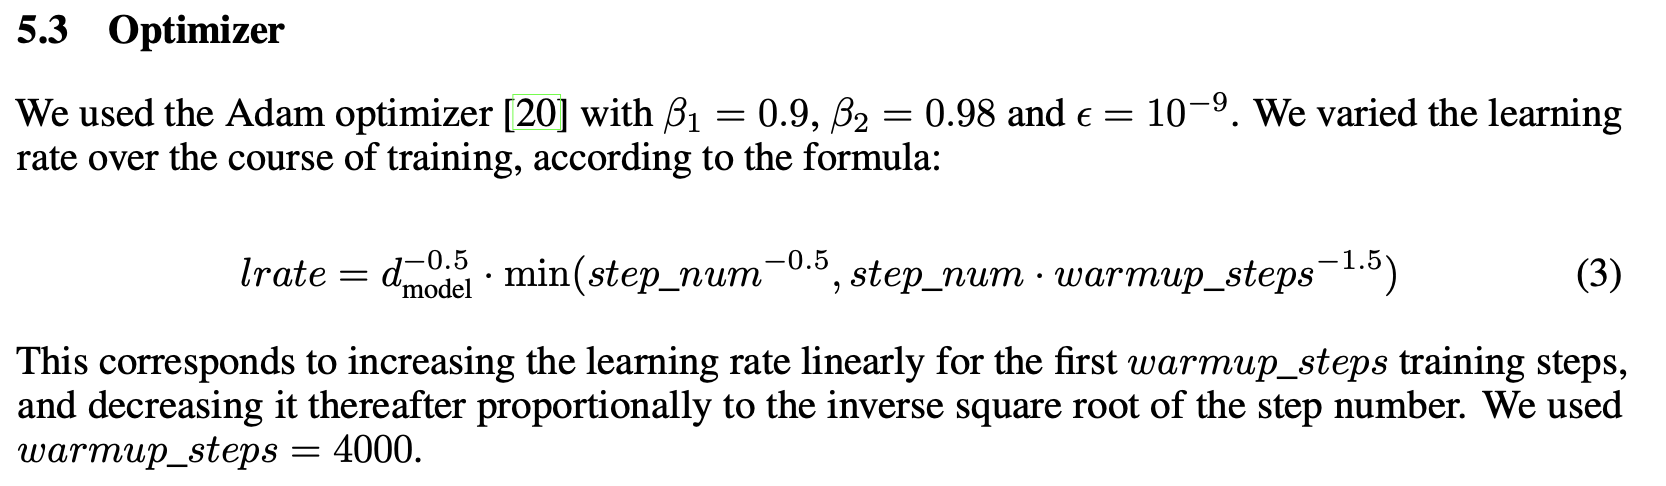

In [18]:
class AdamScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, model_dim, warmup_steps=4000):
        self.model_dim = model_dim
        self.warmup_steps = warmup_steps
        super().__init__(optimizer)

    def get_lr(self):
        step_num = self._step_count + 1
        lr = np.power(self.model_dim, -0.5) * min(np.power(step_num, -0.5), step_num*np.power(self.warmup_steps, -1.5))
        return [lr for _ in self.base_lrs]

100%|█| 20000/20000 [00:


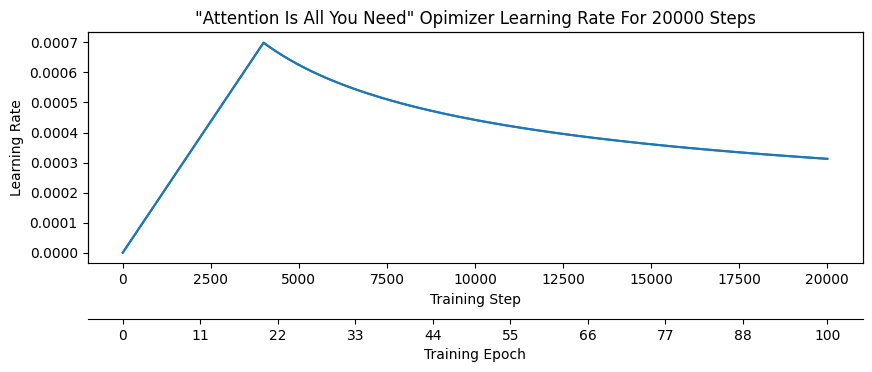

In [23]:
## Visualize the Scheduler rate:
## Do this after instantiating the model below

dummy_epochs = 100
dummy_number_of_batches = len(dataset_bert_tokens_train) // 64

import matplotlib.pyplot as plt

dummy_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
dummy_scheduler = AdamScheduler(dummy_optimizer, model_dim)
lrs = []

for e in tqdm(range(min(dummy_epochs * dummy_number_of_batches, 20_000))):
    lrs.append(dummy_optimizer.param_groups[0]['lr'])
    dummy_optimizer.step()
    dummy_scheduler.step()

fig, ax1 = plt.subplots(figsize=(10,3))
ax2 = ax1.twiny()
ax1.plot(lrs)
ax2.plot(lrs)
ax1.set_title(f'"Attention Is All You Need" Opimizer Learning Rate For {len(lrs)} Steps')
ax1.set_ylabel('Learning Rate')
ax1.set_xlabel('Training Step')
ax2.xaxis.tick_bottom() 
ax2.xaxis.set_label_position('bottom') 
ax2.set_xlabel('Training Epoch') 
ax2.set_xticks(np.linspace(0, dummy_epochs, 10).astype(int) * len(lrs)//dummy_epochs, np.linspace(0, dummy_epochs, 10).astype(int))
ax2.spines['bottom'].set_position(('outward', 40)) 
plt.show()

In [20]:
num_heads = 8
model_dim = 512
ff_dim = 2048
dropout=0.1
batch_size = 64 # wasn't specified in paper

epochs = 10 # wasn't specified in paper

source_vocab_size = english_tokenizer.vocab_size # in this case, the number of possible English tokens
target_vocab_size = german_tokenizer.vocab_size # in this case, the number of possible German tokens
seq_length = max_sequence_length # in this case, the longest sentence which we set to 512


In [21]:
LOAD_STATE = False

model = DAS_TRANSFORMER(num_encoders=6, # as per paper
                        num_decoders=6, # as per paper
                        source_vocab_size=source_vocab_size, 
                        target_vocab_size=target_vocab_size,
                        sequence_length=seq_length,
                        model_dim=model_dim, 
                        num_heads=num_heads, 
                        ff_dim=ff_dim, 
                        dropout=dropout
                       )

model_state_dict_file = 'model_metadata/model_state_dict_large.pth'
num_epochs_file = 'model_metadata/num_epochs_large.pkl'
if LOAD_STATE and os.path.exists(model_state_dict_file) and os.path.exists(num_epochs_file):
    model.load_state_dict(torch.load(model_state_dict_file))
    epochs = max(epochs - pickle.load(open(num_epochs_file, 'rb')), 0)
    print(f"Loaded model state. Epochs left: {epochs}")

**Tip:** On an M1 mac chip, this could take around 12 hours to train. I recommend using [Amazon SageMaker Studio Lab](https://studiolab.sagemaker.aws). They give you a free GPU to use up to 4 hours every day and it's indreibly easy to sign up and upload this notebook to. It'll speed up the training by ~6x

In [388]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [389]:
criterion = nn.CrossEntropyLoss(ignore_index=english_tokenizer.pad_token_id, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = AdamScheduler(optimizer, model_dim)

model.train()
for epoch in range(epochs):
    
    # load in the data by batches
    starting_loss = 9999
    progress_bar = tqdm(range(0, len(dataset_bert_tokens_train), batch_size), desc="Starting")
    for i in progress_bar:
        batch = dataset_bert_tokens_train[i:i+batch_size]
        
        encoder_inputs = tensor(batch['encoder_inputs']).to(device)
        decoder_inputs = tensor(batch['decoder_inputs']).to(device)
        targets = decoder_inputs[:, 1:] # Shift decoder inputs to create targets (tokens we want to predict)
        decoder_inputs = decoder_inputs[:, :-1] # Shift the decoder inputs to exclude the last token
        
        # NOTE: We pass in the decoder inputs that are the actual german because we're employing "Teacher-Forcing"
        # This means, that even when the model generates the next token, we replace it with the correct
        # token (often called the 'gold' token) from the actual german, so the next prediction after this
        # prediction, we're starting from a correct spot. 
        
        optimizer.zero_grad()
        outputs = model(encoder_inputs, decoder_inputs) # Return shape: (batch_size, sequence_length, german_vocab_size)
        output_view = outputs.view(-1, target_vocab_size) # shape into a 2-D vector (batch_size * sequence_length, german_vocab_size)
                  # You can view the reshape here as (# of predicted tokens, vector of odds that the predicted token is each german token)
        
        loss = criterion(output_view, targets.contiguous().view(-1))

        loss.backward()
        optimizer.step()
        scheduler.step() # Scheduler gets called with every step, not epoch
        
        if starting_loss == 9999:
            starting_loss = np.round(loss.item(), 2)
        progress_bar.set_description(f"Epoch {int(epoch+1)} | Loss {loss.item():.4f} | Inital {starting_loss:.2f}")
        
    source_sentence = batch['source_text'][0] 
    target_sentence = batch['target_text'][0] 
    predicted_sentence = german_tokenizer.decode(torch.argmax(outputs, dim=-1)[0][:30])

    print("SOURCE: ",source_sentence)
    print("TARGET: ",target_sentence)
    print("PREDICTED: ", predicted_sentence)
                
    print(f'Epoch {epoch+1}, Loss {loss.item()}')
    
    torch.save(model.state_dict(), model_state_dict_file)
    pickle.dump(epoch+1, open(num_epochs_file, 'wb'))

Epoch 1 | Loss 8.9392 | 


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 1, Loss 8.93924617767334


Epoch 2 | Loss 8.1560 | 


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 2, Loss 8.156041145324707


Epoch 3 | Loss 7.6207 | 


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Die,,, die,,,, die,,,,,, die,,,,,,,,,,,,,
Epoch 3, Loss 7.620712757110596


Epoch 4 | Loss 7.2894 | 


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Die,,, daß,,,, daß die,,,,, die die,,,,, die,,,.,,
Epoch 4, Loss 7.289432525634766


Epoch 5 | Loss 7.0701 | 


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Die,,, daß,,,, daß die,,, der, daß die,,,,, die,,,,,,
Epoch 5, Loss 7.070130348205566


Epoch 6 | Loss 6.8802 | 


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Die,,, daß Präsident,,, daß die,,,,, daß die,,,,, die,,,,,,
Epoch 6, Loss 6.880171775817871


Epoch 7 | Loss 6.7038 | 


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Die möchte,, daß Kommissar,,, daß die,,, und, daß die den,, und, die und und.,,,
Epoch 7, Loss 6.703795909881592


Epoch 8 | Loss 6.5427 | 


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Die möchte,, daß Kommissar,,, daß die,,, und, daß die den,, und und die,,,,, und
Epoch 8, Loss 6.542726516723633


Epoch 9 | Loss 6.3687 | 


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar, die, daß wir,,, und, daß die die und die und und die. und,,, und
Epoch 9, Loss 6.368681907653809


Epoch 10 | Loss 6.2207 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar, die, daß die, und, und, daß ich auf und die und und ich, und. und. zu
Epoch 10, Loss 6.220736503601074


Epoch 11 | Loss 6.0615 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,,, daß wir,,, und, daß ich den, in und, die,..,..
Epoch 11, Loss 6.061489582061768


Epoch 12 | Loss 5.9038 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,,, daß wir, und der und, daß ich die undn und und ich. und... und
Epoch 12, Loss 5.903818130493164


Epoch 13 | Loss 5.7524 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,,, daß die in und der und, daß ich den,n, und ich. der...en
Epoch 13, Loss 5.75239372253418


Epoch 14 | Loss 5.6203 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar, die, daß die, ich der und, daß ich den, die und und ich..... und
Epoch 14, Loss 5.620309352874756


Epoch 15 | Loss 5.5000 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,n, daß wir haben ich, und, daß ich möchte zu zu,, ich..... ist
Epoch 15, Loss 5.49996280670166


Epoch 16 | Loss 5.3625 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,s, daß die die und der und, und ich die und die und und die... und. zu
Epoch 16, Loss 5.362488746643066


Epoch 17 | Loss 5.2303 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß ich, und, und, und ich möchte, in, und ich.,., werdenung
Epoch 17, Loss 5.230282306671143


Epoch 18 | Loss 5.0942 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß ich, Bericht, und, und ich denke, in und und die..... der
Epoch 18, Loss 5.094202041625977


Epoch 19 | Loss 4.9490 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß die in ich der und, und ich die, inn und ich..t und werden zu
Epoch 19, Loss 4.949023723602295


Epoch 20 | Loss 4.8195 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß ich, und in und, daß ich Sie, in, und ich ich,. und. und
Epoch 20, Loss 4.819524765014648


Epoch 21 | Loss 4.6910 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß die in ich in und, und ich den, die und und ich ich,t werden werden,
Epoch 21, Loss 4.690985202789307


Epoch 22 | Loss 4.5799 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß die mir Bericht und und, und ich die und die und und ich ich hatt und werden ist
Epoch 22, Loss 4.579946517944336


Epoch 23 | Loss 4.4628 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß Sie mir ich in und, daß ich möchte und inn und die werden,t und werdenung
Epoch 23, Loss 4.4628448486328125


Epoch 24 | Loss 4.3513 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß ich haben Änderungs von und, und ich Sie, inn und ich ist werdent werden werdenung
Epoch 24, Loss 4.351254940032959


Epoch 25 | Loss 4.2858 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß ich mir Änderungs in und, daß ich die ich inn und ich ich werdent in.ung
Epoch 25, Loss 4.285774230957031


Epoch 26 | Loss 4.1289 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß Sie die Änderungs und und, und ich Sie und in und und die ich werdent in werdenung
Epoch 26, Loss 4.128918647766113


Epoch 27 | Loss 4.0312 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß Sie mir Vorschlag in und, und ich Sie, inn und ich Stellungnahme hatt in werden auch
Epoch 27, Loss 4.031237602233887


Epoch 28 | Loss 3.9273 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich denke,, daß Kommissar,i, daß Sie die Änderungs werden werden, und ich Sie, dien und die Stellungnahmert werden werdenung
Epoch 28, Loss 3.927349090576172


Epoch 29 | Loss 3.8175 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß Sie in Änderungs in und, und ich Ihnen, Kommentaren und ich Stellungnahme werdent werden werdenung
Epoch 29, Loss 3.817498207092285


Epoch 30 | Loss 3.7214 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, Herr Kommissar,i, daß Sie diesen Vorschlag und werden, und ich Sie, inn und ich Stellungnahme zumt werden werdenung
Epoch 30, Loss 3.7214252948760986


Epoch 31 | Loss 3.6614 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, Herr Kommissarini, daß Sie mir Vorschlag zur werden, und ich Sie ich Kommentaren und ich Stellungnahme zumt werden werdent
Epoch 31, Loss 3.661375045776367


Epoch 32 | Loss 3.5304 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß Sie diesen Änderungss werden, und ich Sie und Kommentaren und ich Stellungnahme zumt werden werdenung
Epoch 32, Loss 3.5303683280944824


Epoch 33 | Loss 3.4363 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß Sie diesen Vorschlag zu werden, und ich denke, Kommentaren und ich Stellungnahme zumt werden werdenung
Epoch 33, Loss 3.4362926483154297


Epoch 34 | Loss 3.3426 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich hoffe,, Herr Kommissar,i, daß Sie mir Änderungs für und, und ich denke, Kommentaren und Herren Stellungnahme erwart über werdenuß
Epoch 34, Loss 3.342608690261841


Epoch 35 | Loss 3.2687 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, daß Kommissar,i, daß Sie diesen Änderungs, werden, und ich denke, Kommentaren und ich Stellungnahme erwart werden werdenung
Epoch 35, Loss 3.2686567306518555


Epoch 36 | Loss 3.1811 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, Herr Kommissarini, daß Sie diesen Vorschlag werden werden, und ich Sie ihren Kommentaren und ich Stellungnahme erwart werden werden entgegen
Epoch 36, Loss 3.1811461448669434


Epoch 37 | Loss 3.0910 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich hoffe,, Herr Kommissar,i, daß Sie die Änderungs von werden, und ich Sie ihren Kommentaren und ich Stellungnahme zumt werden werden entgegen
Epoch 37, Loss 3.090981960296631


Epoch 38 | Loss 2.9820 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, Herr Kommissarini, daß Sie diesen Änderungs und werden, und ich denke ihren Kommentaren und ich Stellungnahme zumt werden werden entgegen
Epoch 38, Loss 2.982011318206787


Epoch 39 | Loss 2.9159 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich möchte,, Herr Kommissar Monti, daß Sie diesen Vorschlag werden werden, und ich Sie ihren Kommentaren und ich Stellungnahme zumt werden werden entgegen
Epoch 39, Loss 2.9158592224121094


Epoch 40 | Loss 2.8415 |


SOURCE:  I very much hope that you, Commissioner Monti, will support these amendments, and I look forward to your comments and to finding out where you stand on this matter.
TARGET:  Ich hoffe sehr, Herr Kommissar Monti, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und Ihrer Stellungnahme erwartungsvoll entgegen.
PREDICTED:  Ich hoffe,, Herr Kommissarini, daß Sie diesen Vorschlag unterstützen werden, und ich sehe ihren Kommentaren und ich Stellungnahme erwart und werden entgegen
Epoch 40, Loss 2.8415489196777344


Epoch 41 | Loss 3.0892 |


KeyboardInterrupt: 

### Try it out yourself!

In [22]:
!pip install googletrans==4.0.0-rc1
from googletrans import Translator, LANGUAGES

translator = Translator()

In [23]:
def try_it_out(english:str, temperature:int=1):
    # Tokenize the English sentence
    english_tokens = english_tokenizer(english, return_tensors="pt", padding='max_length', max_length=max_sequence_length)['input_ids']

    # Feed the tokenized sentence into the model
    model.eval() 
    with torch.no_grad(): # No need to calculate gradients for inference
        # Note: We're assuming `model` is the name of your model
        encoder_inputs = english_tokens.to(device)
        # Initial decoder input is a tensor filled with the '[CLS]' token id
        decoder_inputs = torch.full_like(encoder_inputs, german_tokenizer.cls_token_id).to(device)

        for i in range(1, decoder_inputs.size(1)):
            outputs = model(encoder_inputs, decoder_inputs)
            # Take the token with the highest softmax score as the next token
            next_token = torch.argmax(F.softmax(outputs[:, i-1, :]/temperature, dim=-1), dim=-1)

            decoder_inputs[:, i] = next_token

            if german_tokenizer.decode(next_token) == german_tokenizer.sep_token:
                break

        german_tokens = decoder_inputs

    # Decode the output from the model to form the German translation
    german_sentence = german_tokenizer.decode(german_tokens[0], skip_special_tokens=True)
    print("German:", german_sentence)

    retranslated = translator.translate(german_sentence, src='de', dest='en').text
    print("Transformer output re-translated:", retranslated)

In [24]:
temperature = 1

# Note: the dataset is a political one, most sentences are about international affairs. Try something like: "The European Union is a state."
english = "The man is part of the European Union council."
try_it_out(english, temperature)

German: Die erste diesjährige Tagung des Europäischen Unionssidiarität über die Mitgliedstaaten erhalten.
Transformer output re-translated: The first this year's conference of the European Union Synicity through the Member States.


## TODO:
1. Implement byte-pair encoding on the dataset
2. Go over paper results
3. Visualize the attention

### Notes on Transformers:

#### What makes them so good?
- Transfomers, because of multi-head attention, it is able to parrallelize and thus much faster to train with a GPU, making them very efficient models


#### How does their performance compare to other models?
- Transfomers have the ability to preform better than other inter-datapoint models as long as you have a very large set of data
- For example, CNNs are able to learn a lot more with less data, but the marginal benefit of each subsequent data point decreases at a much faster rate than transformers, so over a very large dataset, transformers are able to have higher accuracy
- Transformers demonstrate a great ability to generalize out of their distribution (OOD classification)

#### Other Resouces:
1. [Harvard's NLP article](https://nlp.seas.harvard.edu/2018/04/03/attention.html). 
   - Walks you through transformers. It's very good about learning why the authors chose the different parts of this architecture, and provides lots of citations. 
   - I also Like how it goes over multi-gpu training. Something that is very needed for this expensive models
2. [This article](https://www.lesswrong.com/posts/2kyzD5NddfZZ8iuA7/implementing-a-transformer-from-scratch-in-pytorch-a-write)
    - It was great in that it talks about some common pitfalls that the owner encountered and that I experienced as well. Really good if you're trying to build your own transformer and learn from someone else's mistakes
3. [Attention article](https://www.lesswrong.com/posts/2kyzD5NddfZZ8iuA7/implementing-a-transformer-from-scratch-in-pytorch-a-write)
    - A fantastic first step in learning what attention is and how it came to be
4. [How to efficently train transformers](https://arxiv.org/pdf/1804.00247.pdf)
    - This is a very good paper on the process and common mistakes about training transformers and the trade offs about hyperparameter tuning
5. [Andrej Kaparthy's very useful areticle about trainig models](http://karpathy.github.io/2019/04/25/recipe/)
    - Read this if you're going to implement models on your own. It will same you time, increase your understanding, and provide a great guidline on how to train neural net models.

### Modern Transformers:

#### BERT

#### GPT